<a href="https://colab.research.google.com/github/chrisrichardson/fenics-tutorial/blob/main/poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisson equation

This notebook solves the classic Poisson equation: $$\nabla^2 u = \rho$$ using FEniCS, on a two-dimension square mesh, subject to suitable boundary conditions (e.g. $u=0$ on the boundary).

## Objectives

1. Install FEniCS in colab (can take some time)
2. Create and visualise a simple mesh
3. Solve the Poisson equation for different source terms ($\rho$) and different boundary conditions.

The code is annotated with comments to help you. Please ask if anything is unclear.

In [42]:
# Install FEniCSx packages
try:
    import dolfinx
except ImportError:
    !wget -q -nc "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh" >& err.log
    import dolfinx

In [43]:
# Import all the required modules
from mpi4py import MPI
import numpy as np

# Plotting support
import pyvista
pyvista.global_theme.jupyter_backend = 'static'
pyvista.global_theme.notebook = True

# FEniCS DSL
import ufl
from ufl import grad, dx, TestFunction, TrialFunction, inner

# FEniCS main package
from dolfinx.plot import vtk_mesh
from dolfinx.mesh import create_unit_square, locate_entities_boundary, CellType
from dolfinx.fem import functionspace, dirichletbc, locate_dofs_topological
from dolfinx.fem import form, Constant, Function, Expression, assemble_scalar
from dolfinx.fem import assemble_matrix, assemble_vector, apply_lifting

# Interface to Petsc linear algebra
from dolfinx.fem.petsc import LinearProblem

In [44]:
# Create a unit square with 40 cells in each direction (default triangle cells)
mesh = create_unit_square(MPI.COMM_WORLD, 40, 40)

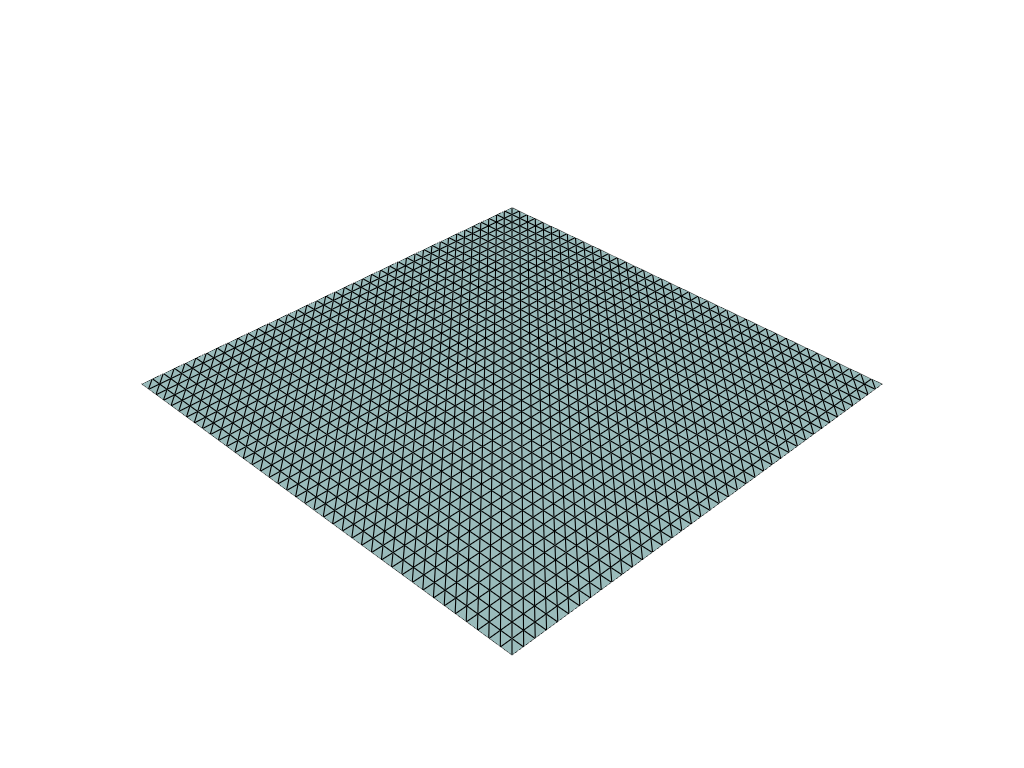

In [45]:
# Visualise mesh
plotter = pyvista.Plotter()
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh));
plotter.add_mesh(grid, show_edges=True)
plotter.show()

In the next section, the Finite Element problem is defined.

First we must choose the "Function Space" for our discretisation. Here, we use the most common, continuous linear space - `("Lagrange", 1)`.

Next, we need to write the equations in symbolic form. These will be compiled to machine code by FEniCS.

In [46]:
# FEniCS definition of the space to solve in, in this case "P1".
V = functionspace(mesh, ("Lagrange", 1))
u, v = TrialFunction(V), TestFunction(V)

# Weak-form definition of Poisson equation
# Left hand side
a = -inner(grad(u), grad(v)) * dx

# Right hand side
x = ufl.SpatialCoordinate(mesh)
rho = ufl.sin(x[0] * 6 * np.pi) * ufl.sin(x[1] * 2 * np.pi)
L = inner(rho, v) * dx


In the next section, the boundary conditions (BCs) are defined.
First, we need to identify the degrees-of-freedom (dofs) which are constrained by the BC.

This is done in two steps, firstly locating the mesh facets (edges) which meet certain geometric criteria (lie close to x=0, x=1, y=0, or y=1). Then, we ask for all dofs which lie on those facets.

Once we know which dofs are to be constrained, we need to give values at those points. Here we just set them to be zero.

In [55]:
# Find edges of the mesh, and associated degrees of freedom (dofs)
facets = locate_entities_boundary(mesh, dim=1,
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[1], 0.0) | np.isclose(x[0], 1.0) | np.isclose(x[1], 1.0))
dofs = locate_dofs_topological(V, 1, facets)

# Fix values at dofs on boundary
w = Function(V)
w.x.array[:] = 0.0
bc = dirichletbc(w, dofs)

Finally, solve the set of linear equations. A simple interface calls the third-party PETSc library to do this.

In [56]:
# Use PETSc to solve the A.x=b linear algebra problem
problem = LinearProblem(a, L, bcs=[bc],
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()


Now we have a solution in `uh`, we can post-process in several ways.

In [57]:
# Print out the number of dofs, and the max and min solution values
print(uh.x.array.shape)
print(uh.x.array.min(), uh.x.array.max())

(1681,)
-0.0025256624353788694 0.002521638789280494


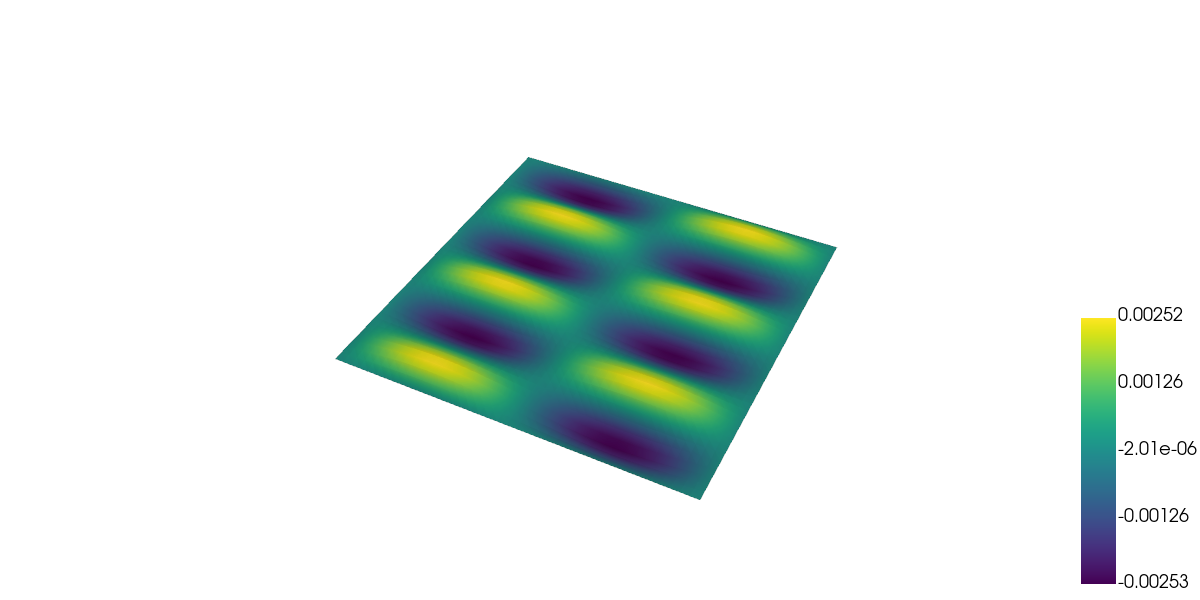

In [58]:
# Plot the solution values on the mesh

plotter = pyvista.Plotter(window_size=([1200,600]))
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh));
grid.point_data["u"] = uh.x.array[:]
grid.set_active_scalars("u")
grid.warp_by_scalar("u", factor=12.0, inplace=True)
plotter.add_mesh(grid, show_edges=False)
plotter.remove_scalar_bar()
plotter.add_scalar_bar(vertical=True)
plotter.camera.position = (2.5, 1.5, 2)
plotter.camera.focal_point = (0.5, 0.5, 0.0)
# plotter.camera.up = (0.0, 0.0, 1.0)
# plotter.camera.zoom(1.0)

plotter.show()


## Task: set different boundary conditions

Go back to the code for the BCs, above and change the line:

`w.x.array[:] = 0.0`

to use

`w.interpolate(lambda x: 0.01*np.sin(12*x[1]))` or an expression of your own choice, and rerun.

In [59]:
# Hint: Use this code to set the BC values, above
w.interpolate(lambda x: 0.01*np.sin(12*x[1]))


## Task: change the source term (RHS)

Make the source term `rho` into a Gaussian, e.g.

$$\rho = e^{-\beta r^2} $$

Since $r$ is not a spatial variable, you will need to define it in terms of `x[0]` and `x[1]`. Make the origin at the centre of the mesh. After editing the code for `rho`, rerun the cells.

In [60]:
# Hint: r2 = (x[0]-0.5)**2 + (x[1]-0.5)**2

### Task: (optional) - look at the generated code (FEniCS internals)

In [ ]:
# You can take a look at the kernel generated code here. It is quite complicated,
# but you will find somewhere a function called "tabulate_tensor" which does the
# actual work...

!cat $HOME/.cache/fenics/libffcx_forms*.c
